In [168]:
import numpy as np
import pandas as pd
import os
import sys
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.path import Path
import xarray as xr
import math

sys.path.append('..//')
from utils import convert_mitgcm_to_epsg_coord

In [169]:
suffix_particle_files = 'jan2026_forecast_r50m'
particle_folders =[ rf"~//parcels_toolbox//02_output//{suffix_particle_files}.zarr"]

plot_dates = [np.datetime64('2026-01-27 09:00:00'),
              np.datetime64('2026-01-27 10:00:00'),
              np.datetime64('2026-01-27 12:00:00'),
              np.datetime64('2026-01-27 16:00:00'),
              np.datetime64('2026-01-28 09:00:00'),
              np.datetime64('2026-01-28 12:00:00'),
              np.datetime64('2026-01-28 15:00:00'),
              np.datetime64('2026-01-28 18:00:00'),
              np.datetime64('2026-01-29 09:00:00'),
              np.datetime64('2026-01-29 12:00:00'),
              np.datetime64('2026-01-29 15:00:00'),
              np.datetime64('2026-01-29 18:00:00'),
              np.datetime64('2026-01-30 09:00:00'),
              np.datetime64('2026-01-30 12:00:00'),
              np.datetime64('2026-01-30 15:00:00'),
              np.datetime64('2026-01-30 18:00:00')] #local

In [170]:
rotate = True

i_scenario = 0
period_seeding = np.timedelta64(0, 'D')


particle_folder = particle_folders[i_scenario]

In [171]:
os.makedirs(".//figures//particles", exist_ok=True)

# Get particles

In [172]:
xr_particules = xr.open_zarr(particle_folder) # obs= time index (0=the moment the particule is seeded), trajectory= particle

In [173]:
arr_time = xr_particules.time.values.flatten()
df_time = pd.Series(arr_time)
df_time = df_time.dropna().drop_duplicates()

In [174]:
df_time

0    2026-01-27 09:00:00
1    2026-01-27 10:00:00
2    2026-01-27 11:00:00
3    2026-01-27 12:00:00
4    2026-01-27 13:00:00
             ...        
83   2026-01-30 20:00:00
84   2026-01-30 21:00:00
85   2026-01-30 22:00:00
86   2026-01-30 23:00:00
87   2026-01-31 00:00:00
Length: 88, dtype: datetime64[ns]

In [175]:
xr_particules['age'] = (xr_particules['time'] - xr_particules['time'].isel(obs=0)).dt.total_seconds() / 86400

### Get wwtp and shoreline coordinates

In [176]:
x_sg_wwtp, y_sg_wwtp = 2534650,1151350
xy_land = np.loadtxt(r"..//coord_sampling//shoreline_epsg2056.txt")

### Filter by initial date

In [177]:
import matplotlib.ticker as ticker

In [178]:
i_plot=0

2026-01-28 09:00:00 


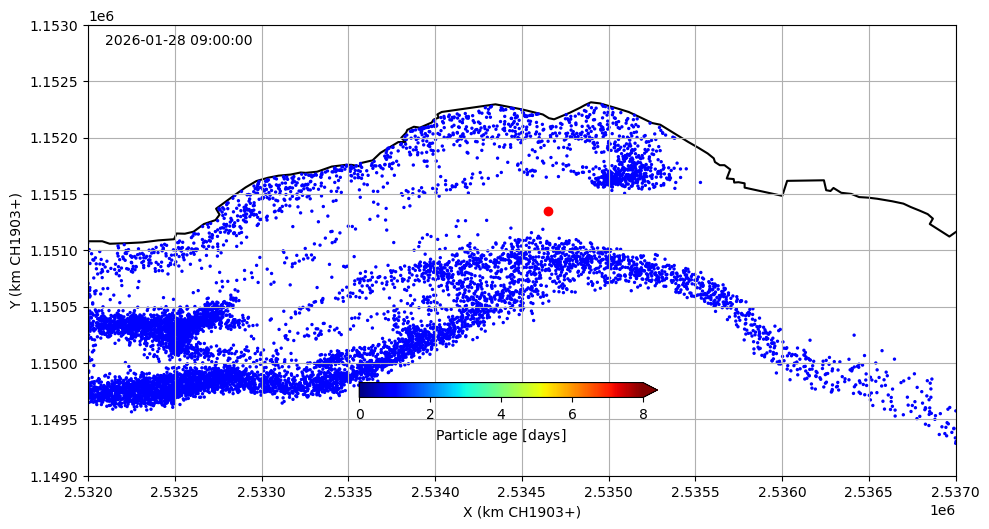

In [186]:
plot_date = plot_dates[i_plot]
dt_naive = plot_date.astype('datetime64').astype(datetime)
str_plot_date = dt_naive.strftime('%Y-%m-%d %H:%M:%S %Z')
str_plot_date_file_names = dt_naive.strftime('%Y-%m-%d_%H-%M-%S_%Z')
print(str_plot_date)

date_start_seeding = plot_date - period_seeding
plot_output_particles_path = rf'.//figures//particles//{str_plot_date_file_names}_{suffix_particle_files}.png'
t_ini = xr_particules.isel(obs=0)['time'].values
pid = xr_particules['trajectory'].values

### Select plot date
snapshot = xr_particules.where(xr_particules['time']==plot_date)
mask_snapshot = ~np.isnan(snapshot.lon.values)
x_part, y_part, z_part, age_part = snapshot["lon"].values[mask_snapshot], snapshot["lat"].values[mask_snapshot], snapshot["z"].values[mask_snapshot], snapshot["age"].values[mask_snapshot]
## Convert particles coordinates to CH1903
# point of origin in swiss grid
X0_SG = 2500000
Y0_SG = 1116500

grid_rotation = 19.411486858683578
if rotate:
    x_part, y_part = convert_mitgcm_to_epsg_coord(x_part, y_part, '2056', X0_SG, Y0_SG, 100, grid_rotation)
# Remove particles outside the lake
polygon = Path(xy_land)
points = np.vstack((x_part, y_part)).T

is_inside = polygon.contains_points(points)

x_inside = x_part[is_inside]
y_inside = y_part[is_inside]
z_inside = z_part[is_inside]
age_inside = age_part[is_inside]

if len(is_inside) != len(x_part):
    print(f'Uhoh, {len(x_part)-len(is_inside)} particules ended up outside the lake...')
# Plot
fig, ax = plt.subplots(figsize=(10,5.5))
#lake contour
plt.plot(xy_land[:,0], xy_land[:,1], color='black', zorder=1)

#particles
scatter = plt.scatter(x_inside, y_inside, 
                      c=age_inside, cmap='jet', s=2, vmin=0, vmax=8)

cbar = plt.colorbar(fraction=0.04,orientation="horizontal",pad=-0.25,extend='max')
cbar.set_label(label='$\mathregular{Particle \ age\ [days]}$')

plt.scatter(x_sg_wwtp, y_sg_wwtp, color='r', zorder=4)

plt.xlim(2526000,2541000)
plt.ylim(1143000,1153000)
plt.xlim(2532000,2537000)
plt.ylim(1149000,1153000)

plt.xlabel("X (km CH1903+)")
plt.ylabel("Y (km CH1903+)")

plt.text(0.02, 0.98, f'{str_plot_date}', transform=plt.gca().transAxes, ha='left', va='top')
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5e3))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5e3))
plt.grid(True)
plt.tight_layout()
fig.savefig(plot_output_particles_path)

i_plot += 1

In [181]:
i_plot -= 1